In [1]:
import argparse
import configparser
import io
import os
from collections import defaultdict

import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Conv2D, Input, ZeroPadding2D, Add,
                                     UpSampling2D, MaxPooling2D, Concatenate)
from tensorflow.keras.layers import LeakyReLU, Layer
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot

import coremltools as ct

print("TensorFlow version is: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version is: {}".format(tf.keras.__version__))

TensorFlow version is: 2.8.0
Eager execution is: True
Keras version is: 2.8.0


# Wraper function

- https://github.com/hunglc007/tensorflow-yolov4-tflite

In [2]:
input_size = 608

In [3]:
import cv2
original_image = cv2.imread('joshua_newnham_4.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image_data = cv2.resize(original_image, (input_size, input_size))
image_data = image_data / 255.
images_data = []
for i in range(1):
    images_data.append(image_data)
images_data = np.asarray(images_data).astype(np.float32)
images_data.shape

(1, 608, 608, 3)

In [4]:
keras_output_path = 'yolov4-608'

In [163]:
from tensorflow.python.saved_model import tag_constants
saved_model_loaded = tf.saved_model.load(keras_output_path, tags=[tag_constants.SERVING])
type(saved_model_loaded)

tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject

In [164]:
infer = saved_model_loaded.signatures['serving_default']
type(infer)

tensorflow.python.saved_model.load._WrapperFunction

In [177]:
batch_data = tf.constant(images_data)
batch_data.shape

TensorShape([1, 608, 608, 3])

In [178]:
pred_bbox = infer(batch_data)
type(pred_bbox)

dict

In [179]:
for key, value in pred_bbox.items():
    boxes = value[:, :, 0:4]
    pred_conf = value[:, :, 4:]

In [180]:
boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
            boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
            scores=tf.reshape(
                pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
            max_output_size_per_class=50,
            max_total_size=50,
            iou_threshold=.45,
            score_threshold=.3
        )

In [181]:
 pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]

In [182]:
import colorsys
import random
def draw_bbox(image, bboxes, classes, allowed_classes, show_label=True):
    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    out_boxes, out_scores, out_classes, num_boxes = bboxes
    for i in range(num_boxes[0]):
        if int(out_classes[0][i]) < 0 or int(out_classes[0][i]) > num_classes: continue
        coor = out_boxes[0][i]
        coor[0] = int(coor[0] * image_h)
        coor[2] = int(coor[2] * image_h)
        coor[1] = int(coor[1] * image_w)
        coor[3] = int(coor[3] * image_w)

        fontScale = 0.5
        score = out_scores[0][i]
        class_ind = int(out_classes[0][i])
        class_name = classes[class_ind]

        # check if class is in allowed classes
        if class_name not in allowed_classes:
            continue
        else:
            bbox_color = colors[class_ind]
            bbox_thick = int(0.6 * (image_h + image_w) / 600)
            c1, c2 = (coor[1], coor[0]), (coor[3], coor[2])
            cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

            if show_label:
                bbox_mess = '%s: %.2f' % (classes[class_ind], score)
                t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick // 2)[0]
                c3 = (c1[0] + t_size[0], c1[1] - t_size[1] - 3)
                cv2.rectangle(image, c1, (np.float32(c3[0]), np.float32(c3[1])), bbox_color, -1) #filled

                cv2.putText(image, bbox_mess, (c1[0], np.float32(c1[1] - 2)), cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale, (0, 0, 0), bbox_thick // 2, lineType=cv2.LINE_AA)
    return image

In [183]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [184]:
# reference https://github.com/AlexeyAB/darknet/blob/master/cfg/coco.names
labels = read_labels('coco.txt')
labels[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [185]:
image = draw_bbox(original_image, pred_bbox, classes =labels, allowed_classes = labels)

/var/folders/zz/4lg5ylr92_d7sjz9ds3lb3h00000gn/T/ipykernel_26216/3214245169.py:35: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)
/var/folders/zz/4lg5ylr92_d7sjz9ds3lb3h00000gn/T/ipykernel_26216/3214245169.py:41: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(image, c1, (np.float32(c3[0]), np.float32(c3[1])), bbox_color, -1) #filled
/var/folders/zz/4lg5ylr92_d7sjz9ds3lb3h00000gn/T/ipykernel_26216/3214245169.py:43: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.putText(image, bbox_mess, (c1[0], np.float32(c1[1] - 2))

In [186]:
type(image)

numpy.ndarray

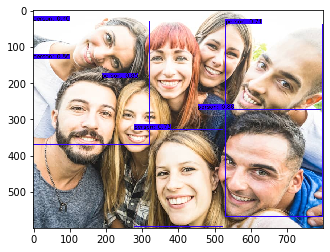

In [187]:
from matplotlib import pyplot as plt
%matplotlib inline 
plt.imshow(image, interpolation='nearest')
plt.show()


#  trying to use model as keras model

In [5]:
y4m = tf.keras.models.load_model(keras_output_path)

In [13]:
type(y4m)

keras.engine.functional.Functional

In [6]:
y4m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 tf_op_layer_AddV2 (TensorFlowO  (None, 304, 304, 64  0          ['tf_op_layer_Mul_3[0][0]',      
 pLayer)                        )                                 'tf_op_layer_Mul_5[0][0]']      
                                                                                                  
 conv2d_6 (Conv2D)              (None, 304, 304, 64  4096        ['tf_op_layer_AddV2[0][0]']      
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 304, 304, 64  4096        ['tf_op_layer_Mul_1[0][0]']      
                                )                                                                 
                                                                                                  
 batch_nor

 OpLayer)                       )                                 'tf_op_layer_Tanh_10[0][0]']    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 152, 152, 64  4096        ['tf_op_layer_Mul_10[0][0]']     
                                )                                                                 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 152, 152, 64  256        ['conv2d_11[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 tf_op_layer_Softplus_11 (Tenso  (None, 152, 152, 64  0          ['batch_normalization_11[0][0]'] 
 rFlowOpLayer)                  )                                                                 
          

 tf_op_layer_Softplus_9 (Tensor  (None, 152, 152, 64  0          ['batch_normalization_9[0][0]']  
 FlowOpLayer)                   )                                                                 
                                                                                                  
 tf_op_layer_Tanh_15 (TensorFlo  (None, 152, 152, 64  0          ['tf_op_layer_Softplus_15[0][0]']
 wOpLayer)                      )                                                                 
                                                                                                  
 tf_op_layer_Tanh_9 (TensorFlow  (None, 152, 152, 64  0          ['tf_op_layer_Softplus_9[0][0]'] 
 OpLayer)                       )                                                                 
                                                                                                  
 tf_op_layer_Mul_15 (TensorFlow  (None, 152, 152, 64  0          ['batch_normalization_15[0][0]', 
 OpLayer) 

 tf_op_layer_Softplus_21 (Tenso  (None, 76, 76, 128)  0          ['batch_normalization_21[0][0]'] 
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_Tanh_21 (TensorFlo  (None, 76, 76, 128)  0          ['tf_op_layer_Softplus_21[0][0]']
 wOpLayer)                                                                                        
                                                                                                  
 tf_op_layer_Mul_21 (TensorFlow  (None, 76, 76, 128)  0          ['batch_normalization_21[0][0]', 
 OpLayer)                                                         'tf_op_layer_Tanh_21[0][0]']    
                                                                                                  
 tf_op_layer_AddV2_3 (TensorFlo  (None, 76, 76, 128)  0          ['tf_op_layer_Mul_19[0][0]',     
 wOpLayer)

 wOpLayer)                                                                                        
                                                                                                  
 tf_op_layer_Mul_26 (TensorFlow  (None, 76, 76, 128)  0          ['batch_normalization_26[0][0]', 
 OpLayer)                                                         'tf_op_layer_Tanh_26[0][0]']    
                                                                                                  
 conv2d_27 (Conv2D)             (None, 76, 76, 128)  147456      ['tf_op_layer_Mul_26[0][0]']     
                                                                                                  
 batch_normalization_27 (BatchN  (None, 76, 76, 128)  512        ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf_op_lay

                                                                                                  
 conv2d_32 (Conv2D)             (None, 76, 76, 128)  16384       ['tf_op_layer_AddV2_8[0][0]']    
                                                                                                  
 batch_normalization_32 (BatchN  (None, 76, 76, 128)  512        ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf_op_layer_Softplus_32 (Tenso  (None, 76, 76, 128)  0          ['batch_normalization_32[0][0]'] 
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_Tanh_32 (TensorFlo  (None, 76, 76, 128)  0          ['tf_op_layer_Softplus_32[0][0]']
 wOpLayer)

 wOpLayer)                                                                                        
                                                                                                  
 tf_op_layer_Mul_36 (TensorFlow  (None, 76, 76, 128)  0          ['batch_normalization_36[0][0]', 
 OpLayer)                                                         'tf_op_layer_Tanh_36[0][0]']    
                                                                                                  
 tf_op_layer_Mul_18 (TensorFlow  (None, 76, 76, 128)  0          ['batch_normalization_18[0][0]', 
 OpLayer)                                                         'tf_op_layer_Tanh_18[0][0]']    
                                                                                                  
 tf_op_layer_concat_2 (TensorFl  (None, 76, 76, 256)  0          ['tf_op_layer_Mul_36[0][0]',     
 owOpLayer)                                                       'tf_op_layer_Mul_18[0][0]']     
          

                                                                                                  
 tf_op_layer_AddV2_11 (TensorFl  (None, 38, 38, 256)  0          ['tf_op_layer_Mul_40[0][0]',     
 owOpLayer)                                                       'tf_op_layer_Mul_42[0][0]']     
                                                                                                  
 conv2d_43 (Conv2D)             (None, 38, 38, 256)  65536       ['tf_op_layer_AddV2_11[0][0]']   
                                                                                                  
 batch_normalization_43 (BatchN  (None, 38, 38, 256)  1024       ['conv2d_43[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf_op_layer_Softplus_43 (Tenso  (None, 38, 38, 256)  0          ['batch_normalization_43[0][0]'] 
 rFlowOpLa

 ormalization)                                                                                    
                                                                                                  
 tf_op_layer_Softplus_48 (Tenso  (None, 38, 38, 256)  0          ['batch_normalization_48[0][0]'] 
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_Tanh_48 (TensorFlo  (None, 38, 38, 256)  0          ['tf_op_layer_Softplus_48[0][0]']
 wOpLayer)                                                                                        
                                                                                                  
 tf_op_layer_Mul_48 (TensorFlow  (None, 38, 38, 256)  0          ['batch_normalization_48[0][0]', 
 OpLayer)                                                         'tf_op_layer_Tanh_48[0][0]']    
          

                                                                                                  
 tf_op_layer_Tanh_53 (TensorFlo  (None, 38, 38, 256)  0          ['tf_op_layer_Softplus_53[0][0]']
 wOpLayer)                                                                                        
                                                                                                  
 tf_op_layer_Mul_53 (TensorFlow  (None, 38, 38, 256)  0          ['batch_normalization_53[0][0]', 
 OpLayer)                                                         'tf_op_layer_Tanh_53[0][0]']    
                                                                                                  
 conv2d_54 (Conv2D)             (None, 38, 38, 256)  589824      ['tf_op_layer_Mul_53[0][0]']     
                                                                                                  
 batch_normalization_54 (BatchN  (None, 38, 38, 256)  1024       ['conv2d_54[0][0]']              
 ormalizat

 tf_op_layer_concat_3 (TensorFl  (None, 38, 38, 512)  0          ['tf_op_layer_Mul_57[0][0]',     
 owOpLayer)                                                       'tf_op_layer_Mul_39[0][0]']     
                                                                                                  
 conv2d_58 (Conv2D)             (None, 38, 38, 512)  262144      ['tf_op_layer_concat_3[0][0]']   
                                                                                                  
 batch_normalization_58 (BatchN  (None, 38, 38, 512)  2048       ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf_op_layer_Softplus_58 (Tenso  (None, 38, 38, 512)  0          ['batch_normalization_58[0][0]'] 
 rFlowOpLayer)                                                                                    
          

 ormalization)                                                                                    
                                                                                                  
 tf_op_layer_Softplus_64 (Tenso  (None, 19, 19, 512)  0          ['batch_normalization_64[0][0]'] 
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_Tanh_64 (TensorFlo  (None, 19, 19, 512)  0          ['tf_op_layer_Softplus_64[0][0]']
 wOpLayer)                                                                                        
                                                                                                  
 tf_op_layer_Mul_64 (TensorFlow  (None, 19, 19, 512)  0          ['batch_normalization_64[0][0]', 
 OpLayer)                                                         'tf_op_layer_Tanh_64[0][0]']    
          

                                                                                                  
 tf_op_layer_Mul_69 (TensorFlow  (None, 19, 19, 512)  0          ['batch_normalization_69[0][0]', 
 OpLayer)                                                         'tf_op_layer_Tanh_69[0][0]']    
                                                                                                  
 tf_op_layer_AddV2_22 (TensorFl  (None, 19, 19, 512)  0          ['tf_op_layer_AddV2_21[0][0]',   
 owOpLayer)                                                       'tf_op_layer_Mul_69[0][0]']     
                                                                                                  
 conv2d_70 (Conv2D)             (None, 19, 19, 512)  262144      ['tf_op_layer_AddV2_22[0][0]']   
                                                                                                  
 conv2d_60 (Conv2D)             (None, 19, 19, 512)  524288      ['tf_op_layer_Mul_59[0][0]']     
          

                                                                                                  
 tf_op_layer_MaxPool_2 (TensorF  (None, 19, 19, 512)  0          ['tf_op_layer_LeakyRelu_2[0][0]']
 lowOpLayer)                                                                                      
                                                                                                  
 tf_op_layer_concat_5 (TensorFl  (None, 19, 19, 2048  0          ['tf_op_layer_MaxPool[0][0]',    
 owOpLayer)                     )                                 'tf_op_layer_MaxPool_1[0][0]',  
                                                                  'tf_op_layer_MaxPool_2[0][0]',  
                                                                  'tf_op_layer_LeakyRelu_2[0][0]']
                                                                                                  
 conv2d_75 (Conv2D)             (None, 19, 19, 512)  1048576     ['tf_op_layer_concat_5[0][0]']   
          

                                                                                                  
 batch_normalization_83 (BatchN  (None, 38, 38, 512)  2048       ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf_op_layer_LeakyRelu_11 (Tens  (None, 38, 38, 512)  0          ['batch_normalization_83[0][0]'] 
 orFlowOpLayer)                                                                                   
                                                                                                  
 conv2d_84 (Conv2D)             (None, 38, 38, 256)  131072      ['tf_op_layer_LeakyRelu_11[0][0]'
                                                                 ]                                
                                                                                                  
 batch_nor

                                                                                                  
 zero_padding2d_5 (ZeroPadding2  (None, 77, 77, 128)  0          ['tf_op_layer_LeakyRelu_19[0][0]'
 D)                                                              ]                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 38, 38, 256)  294912      ['zero_padding2d_5[0][0]']       
                                                                                                  
 batch_normalization_93 (BatchN  (None, 38, 38, 256)  1024       ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf_op_layer_LeakyRelu_21 (Tens  (None, 38, 38, 256)  0          ['batch_normalization_93[0][0]'] 
 orFlowOpL

 conv2d_104 (Conv2D)            (None, 19, 19, 1024  4718592     ['tf_op_layer_LeakyRelu_29[0][0]'
                                )                                ]                                
                                                                                                  
 batch_normalization_102 (Batch  (None, 19, 19, 1024  4096       ['conv2d_104[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 tf_op_layer_LeakyRelu_30 (Tens  (None, 19, 19, 1024  0          ['batch_normalization_102[0][0]']
 orFlowOpLayer)                 )                                                                 
                                                                                                  
 conv2d_105 (Conv2D)            (None, 19, 19, 512)  524288      ['tf_op_layer_LeakyRelu_30[0][0]'
          

                                                                                                  
 tf_op_layer_strided_slice_1 (T  ()                  0           ['tf_op_layer_Shape_1[0][0]']    
 ensorFlowOpLayer)                                                                                
                                                                                                  
 tf_op_layer_strided_slice_2 (T  ()                  0           ['tf_op_layer_Shape_2[0][0]']    
 ensorFlowOpLayer)                                                                                
                                                                                                  
 tf_op_layer_Reshape/shape (Ten  (5,)                0           ['tf_op_layer_strided_slice[0][0]
 sorFlowOpLayer)                                                 ']                               
                                                                                                  
 tf_op_lay

 OpLayer)                       )                                [0]']                            
                                                                                                  
 tf_op_layer_Mul_80 (TensorFlow  (None, 19, 19, 3, 2  0          ['tf_op_layer_Sigmoid_6[0][0]']  
 OpLayer)                       )                                                                 
                                                                                                  
 tf_op_layer_Tile_2 (TensorFlow  (None, 19, 19, 3, 2  0          ['tf_op_layer_Tile_2/multiples[0]
 OpLayer)                       )                                [0]']                            
                                                                                                  
 tf_op_layer_Sub (TensorFlowOpL  (None, 76, 76, 3, 2  0          ['tf_op_layer_Mul_72[0][0]']     
 ayer)                          )                                                                 
          

 tf_op_layer_Sigmoid_2 (TensorF  (None, 76, 76, 3, 8  0          ['tf_op_layer_split[0][3]']      
 lowOpLayer)                    0)                                                                
                                                                                                  
 tf_op_layer_Sigmoid_4 (TensorF  (None, 38, 38, 3, 1  0          ['tf_op_layer_split_1[0][2]']    
 lowOpLayer)                    )                                                                 
                                                                                                  
 tf_op_layer_Sigmoid_5 (TensorF  (None, 38, 38, 3, 8  0          ['tf_op_layer_split_1[0][3]']    
 lowOpLayer)                    0)                                                                
                                                                                                  
 tf_op_layer_Sigmoid_7 (TensorF  (None, 19, 19, 3, 1  0          ['tf_op_layer_split_2[0][2]']    
 lowOpLaye

 tf_op_layer_GreaterEqual (Tens  (None, None)        0           ['tf_op_layer_Max[0][0]']        
 orFlowOpLayer)                                                                                   
                                                                                                  
 tf_op_layer_strided_slice_4 (T  (0,)                0           ['tf_op_layer_Shape_4[0][0]']    
 ensorFlowOpLayer)                                                                                
                                                                                                  
 tf_op_layer_concat_15/values_1  (1,)                0           ['tf_op_layer_Prod[0][0]']       
  (TensorFlowOpLayer)                                                                             
                                                                                                  
 tf_op_layer_strided_slice_5 (T  (1,)                0           ['tf_op_layer_Shape_5[0][0]']    
 ensorFlow

 wOpLayer)                       (None, None, 2)]                                                 
                                                                                                  
 tf_op_layer_concat_16 (TensorF  (2,)                0           ['tf_op_layer_strided_slice_7[0][
 lowOpLayer)                                                     0]',                             
                                                                  'tf_op_layer_concat_16/values_1[
                                                                 0][0]',                          
                                                                  'tf_op_layer_strided_slice_8[0][
                                                                 0]']                             
                                                                                                  
 tf_op_layer_Where_1 (TensorFlo  (None, 1)           0           ['tf_op_layer_Reshape_12[0][0]'] 
 wOpLayer)

                                                                 [0]']                            
                                                                                                  
 tf_op_layer_Reshape_14 (Tensor  (None, None, 80)    0           ['tf_op_layer_GatherV2_1[0][0]', 
 FlowOpLayer)                                                     'tf_op_layer_Reshape_14/shape[0]
                                                                 [0]']                            
                                                                                                  
 tf_op_layer_concat_18 (TensorF  (None, None, 84)    0           ['tf_op_layer_concat_17[0][0]',  
 lowOpLayer)                                                      'tf_op_layer_Reshape_14[0][0]'] 
                                                                                                  
Total params: 64,429,405
Trainable params: 64,363,101
Non-trainable params: 66,304
__________________________

In [7]:
y4m.inputs

[<KerasTensor: shape=(None, 608, 608, 3) dtype=float32 (created by layer 'input_1')>]

In [8]:
y4m.outputs

[<KerasTensor: shape=(None, None, 84) dtype=float32 (created by layer 'tf_op_layer_concat_18')>]

In [9]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [10]:
# Pre-process the image
input_w, input_h = 608, 608
photo_filename = 'joshua_newnham_4.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  800 600
input image (1, 608, 608, 3)


In [11]:
# Run the model
yhat = y4m.predict(image)
print("output:",[a.shape for a in yhat])

output: [(53, 84)]


In [12]:
yhat

array([[[-3.2616165e-03,  5.5929750e-01,  4.4310048e-01, ...,
          2.2360043e-06,  5.5849699e-07,  3.5887294e-07],
        [-2.2377968e-03,  5.5977172e-01,  4.4207522e-01, ...,
          2.9498540e-06,  7.0969611e-07,  5.1498176e-07],
        [ 2.9948937e-02,  1.3173505e-03,  5.7690251e-01, ...,
          2.6550319e-06,  1.8606394e-06,  9.2263144e-07],
        ...,
        [ 5.4535532e-01,  3.9448380e-01,  9.9534887e-01, ...,
          3.3781653e-06,  2.8335381e-07,  2.4594715e-07],
        [ 5.4407734e-01,  3.8822567e-01,  9.9669600e-01, ...,
          3.6208003e-06,  3.8600510e-07,  3.0629838e-07],
        [ 5.4557419e-01,  3.8245401e-01,  9.9353272e-01, ...,
          1.2363156e-05,  1.6898391e-06,  1.4280145e-06]]], dtype=float32)